[View in Colaboratory](https://colab.research.google.com/github/scon012/722-Iteration-4/blob/master/722_Iteration_4_Final.ipynb)

# 2018 Semester 2 - INFOSYS 722 - Iteration 4 - Stephen Connor (8881674)

---
## Configure the VM and prepare to be used for Machine Learning


In [0]:
# For Google Step 1 – install spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.2.2/spark-2.2.2-bin-hadoop2.7.tgz
!tar xf spark-2.2.2-bin-hadoop2.7.tgz
!pip install -q findspark

# Install Pydrive so that the data files can be got from GoogleDrive
!pip install PyDrive

In [0]:
# Check out the hardware environment
!cat /proc/cpuinfo
!cat /proc/meminfo

In [0]:
# For Google Step 2
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.2-bin-hadoop2.7"

In [0]:
# For Google Step 3
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Configure the environment

---



In [0]:
# Other environment imports
from pyspark.sql.functions import datediff, to_date, lit, when, date_sub, col, isnan, count, abs, expr, unix_timestamp, to_timestamp, date_format, year
from pyspark.ml.feature import ChiSqSelector, VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer, MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml import Pipeline

# Required to use PyDrive to get the data from Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Get and inspect the data

---

#### Clean up the old data if required (usually not)

In [0]:
# Clean up the old data
# !ls -al
# !rm "2016-17_standings.csv"
# !rm "2017-18_standings.csv"
# !rm "2016-17_teamBoxScore.csv"
# !rm "2017-18_teamBoxScore.csv"
# !ls -al


#### Prompt for the data from the local file system
---

In [0]:
#############################################################
# Get the data for Colab from the local file system

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

#############################################################

#### Get the data from Google Drive - A prompt will be provided for authentication
---

In [0]:
# Get the data from Google Drive
auth.authenticate_user()

# Download the basketball files
standings1617fileID = '1zP8Ua8NGlhYAkEaACXFMvEeLh8rQ2Jtq'
standings1718fileID = '1XfyfvX-hiI4KcERgLsDsgE1C7_hbgfIC'
boxScore1617fielID = '1bahfh1jOp9brP4CnGg_lywxvjyfmTIMT'
boxScore1718fielID = '1R3jEED7ME4voFajkzAK_IsZM_MGINF8P'

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the data files on Colab
def getGoogleFile(fileId, filename):
  train_downloaded = drive.CreateFile({'id': fileId})
  train_downloaded.GetContentFile(filename)
  return

dummy = getGoogleFile(standings1617fileID, "2016-17_standings.csv")
dummy = getGoogleFile(standings1718fileID, "2017-18_standings.csv")
dummy = getGoogleFile(boxScore1617fielID, "2016-17_teamBoxScore.csv")
dummy = getGoogleFile(boxScore1718fielID, "2017-18_teamBoxScore.csv")

#### Load the data into Spark and preview

---

In [7]:
# Get the data files onto Colab
standings1617 = spark.read.csv("2016-17_standings.csv", header=True, inferSchema=True)
standings1617.show(5)

standings1718 = spark.read.csv("2017-18_standings.csv", header=True, inferSchema=True)
standings1718.show(5)

boxScore1617 = spark.read.csv("2016-17_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1617.show(5)

boxScore1718 = spark.read.csv("2017-18_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1718.show(5)


+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|relPercIndx|mov|srs|pwPerc|pythPerc1391|wpyth1391|lpyth1391|pythPerc165|wpyth165|lpyth165|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+--------

In [8]:
# Update NULL values
# Date: 2017-12-28
# Third Official: Petraitis	Gediminas 

# Show the Null values in each of the dataframes
boxScore1617.filter('IsNull(offFNm3)').show()
boxScore1718.filter('IsNull(offFNm3)').show()

# Show the null values
boxScore1718.filter('IsNull(offFNm3)').select("offLNm3", "offFNm3").show()

# Replace the nulls
boxScore1718 = boxScore1718.na.fill({'offLNm3' : "Gediminas", 'offFNm3' : "Petraitis" })

# Show that there are no more null values
boxScore1718.filter('IsNull(offFNm3)').select("offLNm3", "offFNm3").show()

# Show that the Null values in the 1718 dataframes have gone
boxScore1718.filter('IsNull(offFNm3)').show()

# Show that the values in the 1718 dataframes have been populated
boxScore1718.filter('gmDate == "2017-12-28 00:00:00" AND (teamAbbr == "HOU" OR teamAbbr == "BOS")').show()



+------+------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+------+---------+---------+--------+--------+-------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+------

## For the Box Score preparation - the next set of steps are for the box score data preparation
---

In [9]:
# Create column for the "days since" the start of the season for 2016/17

boxScore1617 = boxScore1617.withColumn('daysSince', datediff(to_date(boxScore1617['gmDate']), to_date(lit('2016-10-25'))))

boxScore1617.show(5)

+-------------------+------+-------+-------+-------+--------+-------+--------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+-------+---------+---------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+----------

In [10]:
# Create column for the "days since" the start of the season for 2017/18

boxScore1718 = boxScore1718.withColumn('daysSince', datediff(to_date(boxScore1718['gmDate']), to_date(lit('2016-10-17'))))
boxScore1718.show(5)

+-------------------+------+-------+-------+-------+---------+-------+---------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+-------+---------+---------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+--------

In [11]:
# Merge the two years dataframes of Games Played data

boxScoreAll = boxScore1617.union(boxScore1718)

print("Box Score 1617:", boxScore1617.count())
print("Box Score 1718:", boxScore1718.count())
print("Box Score All:", boxScoreAll.count())

Box Score 1617: 2460
Box Score 1718: 2460
Box Score All: 4920


In [12]:
# Remove all the "Away" perspective records by selecting only the "Home" records

boxScoreAll = boxScoreAll.filter('teamLoc = "Home"')

print("Box Score All:", boxScoreAll.count())

Box Score All: 2460


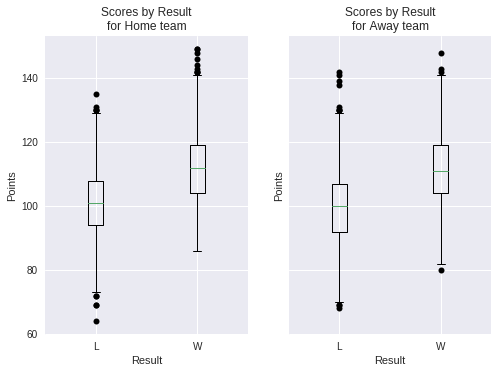

In [13]:
# Visualize the Outliers

myBS = pd.DataFrame(boxScoreAll.take(5000))

plotData = pd.DataFrame(myBS, columns = [13, 16]).rename(inplace=False, index = str, columns = {13:"teamRslt",16:'teamPTS'}).pivot(columns='teamRslt')

# Remove the NaN values from the array and make into a list because they will not be the same length
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
axes[0].boxplot(plotdata, showfliers = True, labels=list('LW'), sym='k')
axes[0].set_title("Scores by Result\nfor Home team")
axes[0].set_xlabel("Result")
axes[0].set_ylabel("Points")

# Repeat again for the away team
plotData = pd.DataFrame(myBS, columns = [69, 72]).rename(inplace=False, index = str, columns = {69:"teamRslt",72:'teamPTS'}).pivot(columns='teamRslt')
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

axes[1].boxplot(plotdata, showfliers = True, labels=list('LW'), sym='k')
axes[1].set_title("Scores by Result\nfor Away team")
plt.xlabel("Result")
plt.ylabel("Points")

fig.subplots_adjust(hspace=50)
plt.show()

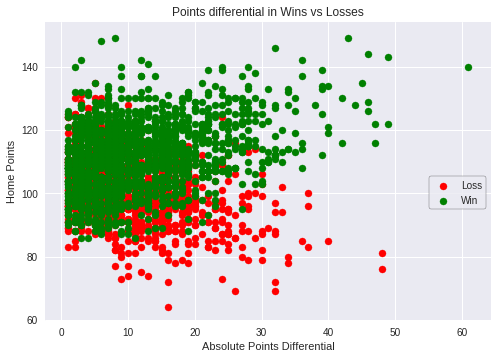

In [14]:
# Compare Home Win/Loss record with scatterplot
boxScoreAll = boxScoreAll.withColumn('teamPTSDiff', abs(boxScoreAll['teamPTS'] - boxScoreAll['opptPTS']))

pdDataFrame = pd.DataFrame(boxScoreAll.toPandas())

cdict = {'Loss': 'red', 'Win': 'green'}
fig, ax = plt.subplots()
for g in np.unique(pdDataFrame.teamRslt):
    ax.scatter(pdDataFrame.teamPTSDiff[pdDataFrame.teamRslt == g], pdDataFrame.teamPTS[pdDataFrame.teamRslt == g], c = cdict[g], label = g, s = 50)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), frameon = True, edgecolor = "black")
plt.title('Points differential in Wins vs Losses')
plt.ylabel('Home Points')
plt.xlabel('Absolute Points Differential')
plt.show()

In [15]:
# Remove the columns that are not known before the game starts by selecting the columns that do. seasTyp is also removed because it is the same for all games 'Regular' - for regular season"
print("Number of rows with 'seasTyp == Regular':", boxScoreAll.filter('seasTyp == "Regular"').count()) # Shows 2460 which is the number of records
print("Number of rows with 'teamLoc == Home':", boxScoreAll.filter('teamLoc == "Home"').count()) # Shows 2460 which is the number of records
print("Number of rows with 'opptLoc == Away':", boxScoreAll.filter('opptLoc == "Away"').count()) # Shows 2460 which is the number of records

# Show that the first name last combinations is the same as the last names on their own. Therefore, the firstname feature does not add any value and is removed
print("Lastnames:", len(np.unique(pdDataFrame.offLNm1)))
print("Firstnames:", len(np.unique(pdDataFrame.offFNm1)))
print("Lastnames and Firstnames:", len(np.unique(pdDataFrame.offLNm1 + pdDataFrame.offLNm1)))

print("Lastnames:", len(np.unique(pdDataFrame.offLNm2)))
print("Firstnames:", len(np.unique(pdDataFrame.offFNm2)))
print("Lastnames and Firstnames:", len(np.unique(pdDataFrame.offLNm2 + pdDataFrame.offLNm2)))

print("Lastnames:", len(np.unique(pdDataFrame.offLNm3)))
print("Firstnames:", len(np.unique(pdDataFrame.offFNm3)))
print("Lastnames and Firstnames:", len(np.unique(pdDataFrame.offLNm3 + pdDataFrame.offLNm3)))

boxScoreAll = boxScoreAll.select('gmDate','gmTime','offLNm1','offLNm2','offLNm3','teamAbbr','teamConf','teamDiv','teamRslt','teamDayOff','opptAbbr','opptConf','opptDiv','opptDayOff','daysSince')

boxScoreAll.show(5)

Number of rows with 'seasTyp == Regular': 2460
Number of rows with 'teamLoc == Home': 2460
Number of rows with 'opptLoc == Away': 2460
Lastnames: 58
Firstnames: 53
Lastnames and Firstnames: 58
Lastnames: 62
Firstnames: 54
Lastnames and Firstnames: 62
Lastnames: 62
Firstnames: 58
Lastnames and Firstnames: 62
+-------------------+------+--------+--------+----------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+
|             gmDate|gmTime| offLNm1| offLNm2|   offLNm3|teamAbbr|teamConf|  teamDiv|teamRslt|teamDayOff|opptAbbr|opptConf|  opptDiv|opptDayOff|daysSince|
+-------------------+------+--------+--------+----------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+
|2016-10-25 00:00:00| 08:00|    Lane|   Adams|   Kennedy|     CLE|    East|  Central|     Win|         0|      NY|    East| Atlantic|         0|        0|
|2016-10-25 00:00:00| 10:00| Buchert|Callahan|     Brown|     POR|    W

In [16]:
# Fix the rows that have the wrong times - they need 12hr deducted from their times
boxScoreAll.filter('gmTime > "12:30"').select('*').show()

boxScoreAll = boxScoreAll.withColumn("gmTime", when(boxScoreAll["gmTime"] > '12:30', date_format(boxScoreAll["gmTime"].cast("timestamp") - expr("INTERVAL 12 HOURS"), "HH:mm")).otherwise(boxScoreAll["gmTime"]))

# Confirm that the data has been updated correctly
boxScoreAll.filter('gmDate == "2017-01-08" AND teamAbbr == "POR" OR gmDate == "2017-01-30" AND teamAbbr == "PHI" OR gmDate == "2017-04-03" AND teamAbbr == "MIN" OR gmDate == "2018-03-21" AND teamAbbr == "NO"').select('*').show()

+-------------------+------+----------+---------+--------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+
|             gmDate|gmTime|   offLNm1|  offLNm2| offLNm3|teamAbbr|teamConf|  teamDiv|teamRslt|teamDayOff|opptAbbr|opptConf|  opptDiv|opptDayOff|daysSince|
+-------------------+------+----------+---------+--------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+
|2017-01-08 00:00:00| 18:00|     Forte|    Scott|    Wood|     POR|    West|Northwest|    Loss|         3|     DET|    East|  Central|         3|       75|
|2017-01-30 00:00:00| 18:00|     Scott|   Taylor|Brothers|     PHI|    East| Atlantic|     Win|         1|     SAC|    West|  Pacific|         2|       97|
|2017-04-03 00:00:00| 19:00| Petraitis| Kirkland|   Zarba|     MIN|    West|Northwest|     Win|         2|     POR|    West|Northwest|         2|      160|
|2018-03-21 00:00:00| 19:00|Fitzgerald|Twardoski|    Lane|      

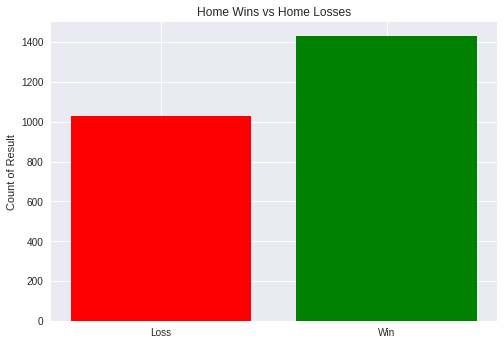

In [19]:
# Compare Home Win/Loss record with bar graph
pdDataFrame = boxScoreAll.toPandas()
objects = np.unique(pdDataFrame.teamRslt)
y_pos = np.arange(len(objects))

counts = [len(pdDataFrame[pdDataFrame['teamRslt'] == "Loss"]), len(pdDataFrame[pdDataFrame['teamRslt'] == "Win"])]
p1 = plt.bar(y_pos, counts, color = ['red', 'green'])

plt.ylabel('Count of Result')
plt.title('Home Wins vs Home Losses')
plt.xticks(y_pos, ('Loss', 'Win'))

plt.show()


## For the Standings preparation - the next set of steps are for the standings data preparation
---

In [20]:
# Join the two years datasets
standingsAll = standings1617.union(standings1718)
standingsAll.show(1)

# Rename the 'teamAbbr' column to prevent clash later
standingsAll = standingsAll.withColumnRenamed('teamAbbr', 'steamAbbr')
standingsAll.show(1)

print("Standings 1617:", standings1617.count())
print("Standings 1718:", standings1718.count()) 
# There are more standings rows in the 17/18 dataset because the season runs for a week longer
print("Standings All:", standingsAll.count())

# Drop the rankOrd column because it duplicates the rank column, also the stk because this is a duplicate of the stkType and stkTot columns
standingsAll = standingsAll.drop('rankOrd')
standingsAll = standingsAll.drop('stk')
standingsAll.show(10)

standingsAll.schema

+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|relPercIndx|mov|srs|pwPerc|pythPerc1391|wpyth1391|lpyth1391|pythPerc165|wpyth165|lpyth165|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+--------

StructType(List(StructField(stDate,TimestampType,true),StructField(steamAbbr,StringType,true),StructField(rank,IntegerType,true),StructField(gameWon,IntegerType,true),StructField(gameLost,IntegerType,true),StructField(stkType,StringType,true),StructField(stkTot,IntegerType,true),StructField(gameBack,DoubleType,true),StructField(ptsFor,IntegerType,true),StructField(ptsAgnst,IntegerType,true),StructField(homeWin,IntegerType,true),StructField(homeLoss,IntegerType,true),StructField(awayWin,IntegerType,true),StructField(awayLoss,IntegerType,true),StructField(confWin,IntegerType,true),StructField(confLoss,IntegerType,true),StructField(lastFive,IntegerType,true),StructField(lastTen,IntegerType,true),StructField(gamePlay,IntegerType,true),StructField(ptsScore,DoubleType,true),StructField(ptsAllow,DoubleType,true),StructField(ptsDiff,DoubleType,true),StructField(opptGmPlay,IntegerType,true),StructField(opptGmWon,IntegerType,true),StructField(opptOpptGmPlay,IntegerType,true),StructField(opptOppt

## Merge the standings data into the box score data
---

In [22]:
# Home team data
boxWithStand = boxScoreAll.join(standingsAll, (boxScoreAll.teamAbbr == standingsAll.steamAbbr) & (date_sub(boxScoreAll.gmDate, 1) == to_date(standingsAll.stDate)))

# Confirm that the counts are the same
print(boxScoreAll.count())
print(boxWithStand.count())

2460
2460


In [23]:
# Away team data

# Rename columns by adding a suffix so that there are no name clashes
opptStandings = standingsAll.select(*(col(x).alias(x + '_oppt') for x in standingsAll.columns))

# Join the tables
boxWithStand = boxWithStand.join(opptStandings, (boxScoreAll.opptAbbr == opptStandings.steamAbbr_oppt) & (date_sub(boxScoreAll.gmDate, 1) == to_date(opptStandings.stDate_oppt)))

# Confirm that the counts are the same
print(boxScoreAll.count())
print(boxWithStand.count())


2460
2460


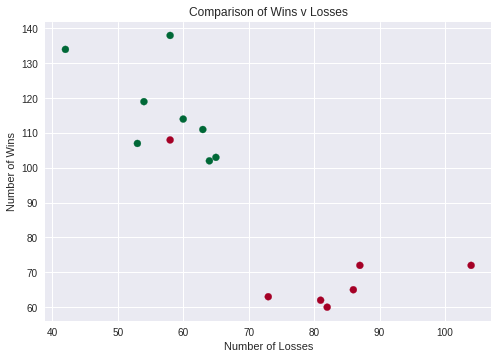

In [25]:
# Compare Win/Loss record with rank

# Prepare the data
pdDataFrame = boxWithStand.toPandas()

# Build up the dataset required for plotting

resultsDf = pd.DataFrame(columns = ['rank', 'Win', 'Loss'])
resultsDf = resultsDf.fillna(0) # with 0s rather than NaNs

for i in range(1, 16):
  df = pdDataFrame.groupby(['rank', 'teamRslt']).get_group((i, 'Win')).aggregate('count')
  df2 = pdDataFrame.groupby(['rank', 'teamRslt']).get_group((i, 'Loss')).aggregate('count')
  vals = { 'rank' : i, 'Win' : df[0], 'Loss' : df2[0]}
  
  newDF = pd.DataFrame(vals, index=[0])
  resultsDf = resultsDf.append(newDF)
  
plt.scatter(resultsDf['Loss'], resultsDf['Win'], c = resultsDf['rank'] < 9, cmap = cm.RdYlGn)
plt.title("Comparison of Wins v Losses")
plt.xlabel("Number of Losses")
plt.ylabel("Number of Wins")
plt.show()


## Split the data and prepare for Machine Learning
---

In [0]:
# Check that there are no NULLS in the dataset before proceeding with the OneHot
# d = trainingData.na.drop()
# print(trainingData.count())
# print(d.count())

# trainingData.head(5000)

### Perform OneHot Encoding
---

In [0]:
###########################################################################
# OneHot the categorical variables so that feature selection and algorithms can be run

# Indexers for Standings Columns
teamAbbr_indexer = StringIndexer(inputCol='teamAbbr',outputCol='teamAbbrIndex')
stkType_indexer = StringIndexer(inputCol='stkType',outputCol='stkTypeIndex')

# Box Score columns
gmTime_indexer = StringIndexer(inputCol='gmTime',outputCol='gmTimeIndex')
offLNm1_indexer = StringIndexer(inputCol='offLNm1',outputCol='offLNm1Index')
offLNm2_indexer = StringIndexer(inputCol='offLNm2',outputCol='offLNm2Index')
offLNm3_indexer = StringIndexer(inputCol='offLNm3',outputCol='offLNm3Index')
teamConf_indexer = StringIndexer(inputCol='teamConf',outputCol='teamConfIndex')
teamDiv_indexer = StringIndexer(inputCol='teamDiv',outputCol='teamDivIndex')
opptAbbr_indexer = StringIndexer(inputCol='opptAbbr',outputCol='opptAbbrIndex')
opptConf_indexer = StringIndexer(inputCol='opptConf',outputCol='opptConfIndex')
opptDiv_indexer = StringIndexer(inputCol='opptDiv',outputCol='opptDivIndex')
teamRslt_indexer = StringIndexer(inputCol='teamRslt',outputCol='rslt')

# Encoders for Standings Columns
teamAbbr_encoder = OneHotEncoder(inputCol='teamAbbrIndex',outputCol='teamAbbrVec')
stkType_encoder = OneHotEncoder(inputCol='stkTypeIndex',outputCol='stkTypeVec')

# Box Score columns
gmTime_encoder = OneHotEncoder(inputCol='gmTimeIndex',outputCol='gmTimeVec')
offLNm1_encoder = OneHotEncoder(inputCol='offLNm1Index',outputCol='offLNm1Vec')
offLNm2_encoder = OneHotEncoder(inputCol='offLNm2Index',outputCol='offLNm2Vec')
offLNm3_encoder = OneHotEncoder(inputCol='offLNm3Index',outputCol='offLNm3Vec')
teamConf_encoder = OneHotEncoder(inputCol='teamConfIndex',outputCol='teamConfVec')
teamDiv_encoder = OneHotEncoder(inputCol='teamDivIndex',outputCol='teamDivVec')
opptAbbr_encoder = OneHotEncoder(inputCol='opptAbbrIndex',outputCol='opptAbbrVec')
opptConf_encoder = OneHotEncoder(inputCol='opptConfIndex',outputCol='opptConfVec')
opptDiv_encoder = OneHotEncoder(inputCol='opptDivIndex',outputCol='opptDivVec')

# Gather the fields back together with the categorical columns replaced with OneHotted vectors
assembler = VectorAssembler(inputCols=['teamAbbrVec','stkTypeVec'
                                       , 'offLNm1Vec','offLNm2Vec','offLNm3Vec','teamConfVec','teamDivVec','opptAbbrVec','opptConfVec','opptDivVec'
                                       , 'gmTimeVec', 'pwPerc', 'mov_oppt', 'pythPerc1391', 'opptOpptGmPlay', 'ptsScore_oppt', 'wpyth1391_oppt'
                                       , 'gameLost', 'relPercIndx', 'mov', 'gamePlay_oppt', 'opptOpptGmWon', 'gameBack', 'sos', 'pwPerc_oppt'
                                       , 'wpyth165_oppt', 'lpyth1391_oppt', 'stkTot', 'awayWin_oppt', 'sos_oppt', 'srs', 'confLoss_oppt'
                                       , 'gameWon', 'lastTen', 'homeWin', 'srs_oppt', 'wpyth165', 'wpyth1391', 'ptsAllow_oppt'
                                       , 'ptsFor', 'lpyth165_oppt', 'confWin', 'homeWin_oppt'
                                       , 'homeLoss', 'confWin_oppt', 'opptGmPlay', 'ptsAllow'
                                       , 'relPercIndx_oppt', 'homeLoss_oppt', 'awayWin', 'teamDayOff', 'lpyth165'
                                       , 'opptDayOff', 'rank_oppt', 'ptsScore', 'ptsAgnst', 'ptsDiff_oppt'
                                       , 'lastFive', 'pythPerc1391_oppt', 'pythPerc165', 'ptsAgnst_oppt', 'stkTot_oppt', 'daysSince'
                                       , 'pythPerc165_oppt', 'gameLost_oppt', 'awayLoss', 'gameBack_oppt', 'awayLoss_oppt', 'lastFive_oppt'
                                       , 'lastTen_oppt', 'rank', 'gameWon_oppt', 'opptGmPlay_oppt', 'lpyth1391', 'opptGmWon_oppt'
                                       , 'ptsDiff', 'gamePlay', 'opptGmWon', 'opptGmPlay_oppt', 'ptsFor_oppt', 'confLoss'
                                       #, 'gmYear'
                                      ], outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=[gmTime_indexer, teamAbbr_indexer, stkType_indexer
                            ,offLNm1_indexer, offLNm2_indexer,offLNm3_indexer, teamConf_indexer, teamDiv_indexer, opptAbbr_indexer, opptConf_indexer, opptDiv_indexer
                            ,teamRslt_indexer
                            ,offLNm1_encoder, offLNm2_encoder,offLNm3_encoder, teamConf_encoder, teamDiv_encoder, opptAbbr_encoder, opptConf_encoder, opptDiv_encoder
                            ,gmTime_encoder,teamAbbr_encoder, stkType_encoder
                            , assembler])

# Apply to the dataframe
#pipeline_model = pipeline.fit(trainingData)
pipeline_model = pipeline.fit(boxWithStand)

# Create the new dataframe
#pipe_df = pipeline_model.transform(trainingData)
pipe_df = pipeline_model.transform(boxWithStand)

In [46]:
print(len(boxWithStand.columns))
pipe_df.show(10, 500)

89
+-------------------+------+----------+----------+----------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+-------------------+---------+----+-------+--------+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+-------------------+--------------+---------+------------+-------------+------------+-----------+-------------+-----------+-------------+------------+-------------+------------+-------------+------------+-------------+-------------+------------+-------------+-------------+-------------+------------+---------------+--------------+-------------------+------------------+--------+----------------+--------+--------+-----------+-----------------+--------------+--------------+----------------+---------

### Perform Feature Selection
---

In [47]:
######################
# Feature Selection

selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selectedFeatures", labelCol="rslt")
selector_of_features = selector.fit(pipe_df)
selected_features = selector_of_features.transform(pipe_df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
selected_features.show(10, 500)

ChiSqSelector output with top 50 features selected
+-------------------+------+----------+----------+----------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+-------------------+---------+----+-------+--------+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+-------------------+--------------+---------+------------+-------------+------------+-----------+-------------+-----------+-------------+------------+-------------+------------+-------------+------------+-------------+-------------+------------+-------------+-------------+-------------+------------+---------------+--------------+-------------------+------------------+--------+----------------+--------+--------+-----------+-----------------+--------

In [0]:
# Select only the selectedFeatures
# chosenFeatures = selected_features.select('rslt', 'selectedFeatures')

# # Rename the 'selectedFeatures' column just 'features'
# chosenFeatures = chosenFeatures.withColumnRenamed('selectedFeatures', 'features')

In [30]:
##############
# Training data - get all the rows that are pre 2018-01-01

trainingData = selected_features.filter('gmDate < "2018-01-01"')
print("All training data:", trainingData.count())
print("All chosen features data:", selected_features.count())

# # Remove the gmDate column - It is no longer required because we have the calculated daysSince column. It was only required to get Training and Test data
#trainingData = trainingData.drop('gmDate')


All training data: 1774
All chosen features data: 2460


In [31]:
trainingData.show()

+-------------------+------+----------+----------+----------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+-------------------+---------+----+-------+--------+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+------+-----------+-----+-------+-------+------------+---------+---------+-----------+--------+--------+-------------------+--------------+---------+------------+-------------+------------+-----------+-------------+-----------+-------------+------------+-------------+------------+-------------+------------+-------------+-------------+------------+-------------+-------------+-------------+------------+---------------+--------------+-------------------+------------------+--------+----------------+--------+--------+-----------+-----------------+--------------+--------------+----------------+--

In [32]:
##############
# Test data - get all the rows that are between 2018-01-01 and 2018-02-07

testData = selected_features.filter('gmDate >= "2018-01-01" AND gmDate <= "2018-02-07"')
print("Test data:", testData.count())

# # Remove the gmDate column - It is no longer required because we have the calculated daysSince column. It was only required to get Training and Test data
#testData = testData.drop('gmDate')

Test data: 260


In [0]:
# # Remove all variables other than features and label
# trainingData = trainingData.select('rslt', 'features')
# testData = testData.select('rslt', 'features')
# # pipe_df.head(10)


In [33]:
# Further split the data into training and validation sets
# Split the Training data into 70 Training & 30 Validation
trainData, validationData = trainingData.randomSplit([0.7,0.3])
print("All data:", selected_features.count())
print("Training data:", trainData.count())
print("Validation data:", validationData.count())


All data: 2460
Training data: 1249
Validation data: 525


# Data Mining
---
#### For each algorithm, perform a parameter sweep and then use the optimal paramters in the final model.

## Iteration 1

In [0]:
# Run the Binomial Logistic Regression Model Parameter Sweep - compare parameters for the algorithm

summary_columns = ['accuracy','regParam','elastic_net_param','threshold']
summary_vals = [(0.0,0.0,0.0,0.0)]
summary_stats = spark.createDataFrame(summary_vals,summary_columns)

for regParam in range(1, 2, 1):
  regParam = regParam / 10
  for elastic_net_param in range(0, 2, 1):
    elastic_net_param = elastic_net_param / 10
    for threshold in range(48, 54, 1):
      threshold = threshold / 100

      # Instantiate the model.
      lr_model = LogisticRegression(featuresCol='selectedFeatures',labelCol='rslt', maxIter=100, regParam=regParam, elasticNetParam=elastic_net_param, threshold=threshold)
      
      # Fit the model.
      lr_model = lr_model.fit(trainData)

      # And evaluate the model using the test data.
      results = lr_model.transform(validationData)
      
      # Calculate the accuracy
      summary = results.withColumn('match', abs(results['rslt'] - results['prediction'])).select('rslt', 'prediction','match')
      accuracy = 1 - summary.select('match').groupBy().sum().collect()[0][0] / summary.select('match').groupBy().count().collect()[0][0]
      
      new_row = spark.createDataFrame([(accuracy, regParam, elastic_net_param, threshold)])
      new_row.head()
      print(accuracy, regParam, elastic_net_param, threshold)
      summary_stats = summary_stats.union(new_row)
      
best_accuracy = summary_stats.groupby().max('accuracy').collect()[0][0]
print('Best accuracy:', best_accuracy, 'has parameters', summary_stats.filter(summary_stats.accuracy == best_accuracy).collect()[0][1:4])      


In [40]:
# Build the final Logistic Regression model using the parameters discovered above using all the training data and use the test data to check accuracy.

# Instantiate the model.
final_lr_model = LogisticRegression(featuresCol='selectedFeatures',labelCol='rslt', maxIter=100, regParam=0.1, elasticNetParam=0.1, threshold=0.48)

# Fit the model.
final_lr_model = final_lr_model.fit(trainingData)

# And evaluate the model using the test data.
final_lr_results = final_lr_model.transform(testData)

# Calculate the accuracy
final_lr_summary = final_lr_results.withColumn('match', abs(final_lr_results['rslt'] - final_lr_results['prediction'])).select('rslt', 'prediction','match')
final_lr_accuracy = 1 - final_lr_summary.select('match').groupBy().sum().collect()[0][0] / final_lr_summary.select('match').groupBy().count().collect()[0][0]
print("Percentage correctly predicted for the final Binomial Logistic Regression model using the Test dataset:", final_lr_accuracy * 100)

Percentage correctly predicted for the final Binomial Logistic Regression model using the Test dataset: 66.53846153846155


In [0]:
# Run the Random Forest Model Parameter Sweep - compare parameters for the algorithm
summary_columns = ['accuracy','num_trees','max_depth','min_instances']
summary_vals = [(0.0,0.0,0.0,0.0)]
summary_stats = spark.createDataFrame(summary_vals,summary_columns)

for num_trees in range(90, 130, 20):
  for max_depth in range(5, 35, 5):
    for min_instances_per_node in range(1, 10):
      # Instantiate the model.
      rf_model = RandomForestClassifier(labelCol="rslt", featuresCol="selectedFeatures", numTrees=num_trees, maxDepth=max_depth, minInstancesPerNode=min_instances_per_node)
      
      # Fit the model.
      rf_model = rf_model.fit(trainData)

      # And evaluate the model using the test data.
      results = rf_model.transform(validationData)
      
      # Calculate the accuracy
      summary = results.withColumn('match', abs(results['rslt'] - results['prediction'])).select('rslt', 'prediction','match')
      accuracy = 1 - summary.select('match').groupBy().sum().collect()[0][0] / summary.select('match').groupBy().count().collect()[0][0]
      
      new_row = spark.createDataFrame([(accuracy, num_trees, max_depth, min_instances_per_node)])
      new_row.head()
      print(accuracy, num_trees, max_depth, min_instances_per_node)
      summary_stats = summary_stats.union(new_row)
      
best_accuracy = summary_stats.groupby().max('accuracy').collect()[0][0]
print('Best accuracy:', best_accuracy, 'has parameters', summary_stats.filter(summary_stats.accuracy == best_accuracy).collect()[0][1:4])      
summary_stats.toPandas().to_csv('rf_summary.csv', index=False)

In [294]:
# Build the final Random Forest model using the parameters discovered above using all the training data and use the test data to check accuracy.

# Instantiate the model.
final_rf_model = RandomForestClassifier(labelCol="rslt", featuresCol="selectedFeatures", numTrees=90, maxDepth=25, minInstancesPerNode=4)

# Fit the model.
final_rf_model = final_rf_model.fit(trainingData)

# And evaluate the model using the test data.
final_rf_results = final_rf_model.transform(testData)

# Calculate the accuracy
final_rf_summary = final_rf_results.withColumn('match', abs(final_rf_results['rslt'] - final_rf_results['prediction'])).select('rslt', 'prediction','match')
final_rf_accuracy = 1 - final_rf_summary.select('match').groupBy().sum().collect()[0][0] / final_rf_summary.select('match').groupBy().count().collect()[0][0]
print("Percentage correctly predicted for the final Random Forest model using the Test dataset:", final_rf_accuracy * 100)

Percentage correctly predicted for the final Random Forest model using the Test dataset: 60.769230769230774


In [0]:
# Run the Multilayer Perceptron Model Parameter Sweep - compare parameters for the algorithm
summary_columns = ['accuracy','layer1','layer2','layer3']
summary_vals = [(0.0,0.0,0.0,0.0)]
summary_stats = spark.createDataFrame(summary_vals,summary_columns)

for layer1 in range(20, 50, 10):
  for layer2 in range(10, 40, 10):
    for layer3 in range(5, 30, 5):
      # Instantiate the model.
      layers = [50, layer1, layer2, layer3, 2]
      nn_model = MultilayerPerceptronClassifier(labelCol="rslt", featuresCol="selectedFeatures", maxIter = 100, layers = layers, blockSize = 128)

      # Fit the model.
      nn_model = nn_model.fit(trainData)

      # And evaluate the model using the test data.
      results = nn_model.transform(validationData)

      # Calculate the accuracy
      summary = results.withColumn('match', abs(results['rslt'] - results['prediction'])).select('rslt', 'prediction','match')
      accuracy = 1 - summary.select('match').groupBy().sum().collect()[0][0] / summary.select('match').groupBy().count().collect()[0][0]

      new_row = spark.createDataFrame([(accuracy, layer1, layer2, layer3)])
      new_row.head()
      print(accuracy, layer1, layer2, layer3)
      summary_stats = summary_stats.union(new_row)
      
best_accuracy = summary_stats.groupby().max('accuracy').collect()[0][0]
print('Best accuracy:', best_accuracy, 'has parameters', summary_stats.filter(summary_stats.accuracy == best_accuracy).collect()[0][1:4])      
summary_stats.toPandas().to_csv('rf_summary.csv', index=False)

In [296]:
# Build the final Multilayer Perceptron model using the parameters discovered above using all the training data and use the test data to check accuracy.

# Instantiate the model.
layers = [50, 20, 10, 20, 2]
final_nn_model = MultilayerPerceptronClassifier(labelCol="rslt", featuresCol="selectedFeatures", maxIter = 100, layers = layers, blockSize = 128)

# Fit the model.
final_nn_model = final_nn_model.fit(trainingData)

# And evaluate the model using the test data.
final_nn_results = final_nn_model.transform(testData)

# Calculate the accuracy
final_nn_summary = final_nn_results.withColumn('match', abs(final_nn_results['rslt'] - final_nn_results['prediction'])).select('rslt', 'prediction','match')
final_nn_accuracy = 1 - final_nn_summary.select('match').groupBy().sum().collect()[0][0] / final_nn_summary.select('match').groupBy().count().collect()[0][0]
print("Percentage correctly predicted for the final Neural Network model using the Test dataset:", final_nn_accuracy * 100)

Percentage correctly predicted for the final Neural Network model using the Test dataset: 64.23076923076923


In [297]:
trainingData.show(10, 500)
testData.show(10, 500)

+-------------------+------+----------+----------+----------+--------+--------+---------+--------+----------+--------+--------+---------+----------+---------+-------------------+---------+----+-------+--------+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+-------------------+--------------+---------+------------+-------------+------------+-----------+-------------+-----------+-------------+------------+-------------+------------+-------------+------------+-------------+-------------+------------+-------------+-------------+-------------+------------+---------------+--------------+-------------------+------------------+--------+----------------+--------+--------+-----------+-----------------+--------------+--------------+----------------+------------

## Iteration 2

### Try to improve predictions using a MinMax Scaler
---

In [55]:
# Scale all values in the vector to between 0 and 1
scaler = MinMaxScaler(inputCol="selectedFeatures", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(trainingData)

# rescale each feature to range [min, max].
scaledValidationData = scalerModel.transform(validationData)
scaledTrainData = scalerModel.transform(trainData)
scaledTrainingData = scalerModel.transform(trainingData)
scaledTestData = scalerModel.transform(testData)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("selectedFeatures", "scaledFeatures").show(20, 500)

Features scaled to range: [0.000000, 1.000000]
+------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                          selectedFeatures|                                                                                                                                                                                                                                                                                                                 

In [59]:
# Run the Binomial Logistic Regression Model Parameter Sweep - compare parameters for the algorithm

summary_columns = ['accuracy','regParam','elastic_net_param','threshold']
summary_vals = [(0.0,0.0,0.0,0.0)]
summary_stats = spark.createDataFrame(summary_vals,summary_columns)

for regParam in range(1, 2, 1):
  regParam = regParam / 10
  for elastic_net_param in range(0, 2, 1):
    elastic_net_param = elastic_net_param / 10
    for threshold in range(48, 54, 1):
      threshold = threshold / 100

      # Instantiate the model.
      lr_model = LogisticRegression(featuresCol='scaledFeatures',labelCol='rslt', maxIter=100, regParam=regParam, elasticNetParam=elastic_net_param, threshold=threshold)
      
      # Fit the model.
      lr_model = lr_model.fit(scaledTrainData)

      # And evaluate the model using the test data.
      results = lr_model.transform(scaledValidationData)
      
      # Calculate the accuracy
      summary = results.withColumn('match', abs(results['rslt'] - results['prediction'])).select('rslt', 'prediction','match')
      accuracy = 1 - summary.select('match').groupBy().sum().collect()[0][0] / summary.select('match').groupBy().count().collect()[0][0]
      
      new_row = spark.createDataFrame([(accuracy, regParam, elastic_net_param, threshold)])
      new_row.head()
      print(accuracy, regParam, elastic_net_param, threshold)
      summary_stats = summary_stats.union(new_row)
      
best_accuracy = summary_stats.groupby().max('accuracy').collect()[0][0]
print('Best accuracy:', best_accuracy, 'has parameters', summary_stats.filter(summary_stats.accuracy == best_accuracy).collect()[0][1:4])   

0.6495238095238095 0.1 0.0 0.48
0.6361904761904762 0.1 0.0 0.49
0.6457142857142857 0.1 0.0 0.5
0.6438095238095238 0.1 0.0 0.51
0.641904761904762 0.1 0.0 0.52
0.6476190476190475 0.1 0.0 0.53
0.6514285714285715 0.1 0.1 0.48
0.6457142857142857 0.1 0.1 0.49
0.641904761904762 0.1 0.1 0.5
0.6438095238095238 0.1 0.1 0.51
0.6438095238095238 0.1 0.1 0.52
0.64 0.1 0.1 0.53
Best accuracy: 0.6514285714285715 has parameters (0.1, 0.1, 0.48)


In [60]:
# Build the final Logistic Regression model using the parameters discovered above using all the training data and use the test data to check accuracy.

# Instantiate the model.
final_lr_model = LogisticRegression(featuresCol='scaledFeatures',labelCol='rslt', maxIter=100, regParam=0.1, elasticNetParam=0.1, threshold=0.48)

# Fit the model.
final_lr_model = final_lr_model.fit(scaledTrainingData)

# And evaluate the model using the test data.
final_lr_results = final_lr_model.transform(scaledTestData)

# Calculate the accuracy
final_lr_summary = final_lr_results.withColumn('match', abs(final_lr_results['rslt'] - final_lr_results['prediction'])).select('rslt', 'prediction','match')
final_lr_accuracy = 1 - final_lr_summary.select('match').groupBy().sum().collect()[0][0] / final_lr_summary.select('match').groupBy().count().collect()[0][0]
print("Percentage correctly predicted for the final Binomial Logistic Regression model using the Test dataset:", final_lr_accuracy * 100)

Percentage correctly predicted for the final Binomial Logistic Regression model using the Test dataset: 66.53846153846155


In [61]:
# Run the Random Forest Model Parameter Sweep - compare parameters for the algorithm
summary_columns = ['accuracy','num_trees','max_depth','min_instances']
summary_vals = [(0.0,0.0,0.0,0.0)]
summary_stats = spark.createDataFrame(summary_vals,summary_columns)

for num_trees in range(90, 130, 20):
  for max_depth in range(5, 35, 5):
    for min_instances_per_node in range(1, 10):
      # Instantiate the model.
      rf_model = RandomForestClassifier(labelCol="rslt", featuresCol="scaledFeatures", numTrees=num_trees, maxDepth=max_depth, minInstancesPerNode=min_instances_per_node)
      
      # Fit the model.
      rf_model = rf_model.fit(scaledTrainData)

      # And evaluate the model using the test data.
      results = rf_model.transform(scaledValidationData)
      
      # Calculate the accuracy
      summary = results.withColumn('match', abs(results['rslt'] - results['prediction'])).select('rslt', 'prediction','match')
      accuracy = 1 - summary.select('match').groupBy().sum().collect()[0][0] / summary.select('match').groupBy().count().collect()[0][0]
      
      new_row = spark.createDataFrame([(accuracy, num_trees, max_depth, min_instances_per_node)])
      new_row.head()
      print(accuracy, num_trees, max_depth, min_instances_per_node)
      summary_stats = summary_stats.union(new_row)
      
best_accuracy = summary_stats.groupby().max('accuracy').collect()[0][0]
print('Best accuracy:', best_accuracy, 'has parameters', summary_stats.filter(summary_stats.accuracy == best_accuracy).collect()[0][1:4])      
summary_stats.toPandas().to_csv('rf_summary.csv', index=False)

0.6152380952380953 90 5 1
0.6038095238095238 90 5 2
0.6190476190476191 90 5 3
0.6247619047619047 90 5 4
0.6190476190476191 90 5 5
0.6228571428571428 90 5 6
0.6323809523809524 90 5 7
0.6266666666666667 90 5 8
0.6190476190476191 90 5 9
0.6076190476190476 90 10 1
0.6152380952380953 90 10 2
0.6152380952380953 90 10 3
0.6247619047619047 90 10 4
0.6209523809523809 90 10 5
0.6152380952380953 90 10 6
0.6152380952380953 90 10 7
0.6076190476190476 90 10 8
0.6304761904761904 90 10 9
0.6038095238095238 90 15 1
0.6095238095238096 90 15 2
0.6285714285714286 90 15 3
0.6171428571428572 90 15 4
0.6152380952380953 90 15 5
0.6114285714285714 90 15 6
0.6019047619047619 90 15 7
0.6 90 15 8
0.6209523809523809 90 15 9
0.6019047619047619 90 20 1
0.6171428571428572 90 20 2
0.6323809523809524 90 20 3
0.6190476190476191 90 20 4
0.6076190476190476 90 20 5
0.6114285714285714 90 20 6
0.6057142857142856 90 20 7
0.6076190476190476 90 20 8
0.6228571428571428 90 20 9
0.6 90 25 1
0.6209523809523809 90 25 2
0.63619047619

In [62]:
# Build the final Random Forest model using the parameters discovered above using all the training data and use the test data to check accuracy.

# Instantiate the model.
final_rf_model = RandomForestClassifier(labelCol="rslt", featuresCol="scaledFeatures", numTrees=110, maxDepth=15, minInstancesPerNode=8)

# Fit the model.
final_rf_model = final_rf_model.fit(scaledTrainingData)

# And evaluate the model using the test data.
final_rf_results = final_rf_model.transform(scaledTestData)

# Calculate the accuracy
final_rf_summary = final_rf_results.withColumn('match', abs(final_rf_results['rslt'] - final_rf_results['prediction'])).select('rslt', 'prediction','match')
final_rf_accuracy = 1 - final_rf_summary.select('match').groupBy().sum().collect()[0][0] / final_rf_summary.select('match').groupBy().count().collect()[0][0]
print("Percentage correctly predicted for the final Random Forest model using the Test dataset:", final_rf_accuracy * 100)

Percentage correctly predicted for the final Random Forest model using the Test dataset: 65.0


In [57]:
# Run the Multilayer Perceptron Model Parameter Sweep - compare parameters for the algorithm
summary_columns = ['accuracy','layer1','layer2','layer3']
summary_vals = [(0.0,0.0,0.0,0.0)]
summary_stats = spark.createDataFrame(summary_vals,summary_columns)

for layer1 in range(20, 50, 10):
  for layer2 in range(10, 40, 10):
    for layer3 in range(5, 30, 5):
      # Instantiate the model.
      layers = [50, layer1, layer2, layer3, 2]
      nn_model = MultilayerPerceptronClassifier(labelCol="rslt", featuresCol="scaledFeatures", maxIter = 100, layers = layers, blockSize = 128)

      # Fit the model.
      nn_model = nn_model.fit(scaledTrainData)

      # And evaluate the model using the test data.
      results = nn_model.transform(scaledValidationData)

      # Calculate the accuracy
      summary = results.withColumn('match', abs(results['rslt'] - results['prediction'])).select('rslt', 'prediction','match')
      accuracy = 1 - summary.select('match').groupBy().sum().collect()[0][0] / summary.select('match').groupBy().count().collect()[0][0]

      new_row = spark.createDataFrame([(accuracy, layer1, layer2, layer3)])
      new_row.head()
      print(accuracy, layer1, layer2, layer3)
      summary_stats = summary_stats.union(new_row)
      
best_accuracy = summary_stats.groupby().max('accuracy').collect()[0][0]
print('Best accuracy:', best_accuracy, 'has parameters', summary_stats.filter(summary_stats.accuracy == best_accuracy).collect()[0][1:4])      
summary_stats.toPandas().to_csv('rf_summary.csv', index=False)

0.6 20 10 5
0.5866666666666667 20 10 10
0.5885714285714285 20 10 15
0.6152380952380953 20 10 20
0.6 20 10 25
0.6 20 20 5
0.6304761904761904 20 20 10
0.5866666666666667 20 20 15
0.598095238095238 20 20 20
0.6152380952380953 20 20 25
0.5676190476190477 20 30 5
0.5904761904761905 20 30 10
0.6 20 30 15
0.5828571428571429 20 30 20
0.6057142857142856 20 30 25
0.6152380952380953 30 10 5
0.5847619047619048 30 10 10
0.5866666666666667 30 10 15
0.6171428571428572 30 10 20
0.5695238095238095 30 10 25
0.6247619047619047 30 20 5
0.6171428571428572 30 20 10
0.6152380952380953 30 20 15
0.5866666666666667 30 20 20
0.6076190476190476 30 20 25
0.6057142857142856 30 30 5
0.598095238095238 30 30 10
0.6095238095238096 30 30 15
0.579047619047619 30 30 20
0.6304761904761904 30 30 25
0.6171428571428572 40 10 5
0.6114285714285714 40 10 10
0.6133333333333333 40 10 15
0.5961904761904762 40 10 20
0.6171428571428572 40 10 25
0.5961904761904762 40 20 5
0.5904761904761905 40 20 10
0.6552380952380952 40 20 15
0.60761

In [58]:
# Build the final Multilayer Perceptron model using the parameters discovered above using all the training data and use the test data to check accuracy.

# Instantiate the model.
layers = [50, 40, 20, 15, 2]
final_nn_model = MultilayerPerceptronClassifier(labelCol="rslt", featuresCol="scaledFeatures", maxIter = 100, layers = layers, blockSize = 128)

# Fit the model.
final_nn_model = final_nn_model.fit(scaledTrainingData)

# And evaluate the model using the test data.
final_nn_results = final_nn_model.transform(scaledTestData)

# Calculate the accuracy
final_nn_summary = final_nn_results.withColumn('match', abs(final_nn_results['rslt'] - final_nn_results['prediction'])).select('rslt', 'prediction','match')
final_nn_accuracy = 1 - final_nn_summary.select('match').groupBy().sum().collect()[0][0] / final_nn_summary.select('match').groupBy().count().collect()[0][0]
print("Percentage correctly predicted for the final Neural Network model using the Test dataset:", final_nn_accuracy * 100)

Percentage correctly predicted for the final Neural Network model using the Test dataset: 66.15384615384615
